<a href="https://colab.research.google.com/github/amitmakashir/Deep-learning/blob/master/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [0]:
# Network structure

hidden_units = [1024,1024,1024,1024,1024]     # hidden_units[0] => 1024 hidden units in the first layer 
output_nodes = 10
input_nodes = 784


no_of_train_images = len(mnist.train.images)
# Hyperparameters
learning_rate = 0.001
epochs = 100
minibatch_size = 350
num_iters = no_of_train_images // minibatch_size

In [0]:
# Create placeholders for input X and labels y
x = tf.placeholder(tf.float32, [None, 784])
y_true = tf.placeholder(tf.float32, [None, 10])


# Constructs a neural network with the specified inputs, outputs and hidden layers
# hidden_units is a list containing hidden units at every hidden layer
# the length of hidden_units list determines the no of hidden layers
# the output_nodes determine the no of classes to be predicted
# Currently use the "He" initialization for initializing the weights
def construct_network(input_nodes, output_nodes, hidden_units):
  no_of_hidden_layers = len(hidden_units)
  W = []
  b = []
  
  initializer = tf.contrib.layers.variance_scaling_initializer()
  
  for i in range(no_of_hidden_layers + 1):
    if i == 0:   # First layer
      w = tf.Variable(initializer([input_nodes, hidden_units[i]]), dtype=tf.float32)
      bias = tf.Variable(tf.random_normal([hidden_units[i]]), dtype=tf.float32)
      
    elif i == no_of_hidden_layers:  # Last layer
      w = tf.Variable(initializer([hidden_units[i-1], output_nodes]), dtype=tf.float32)
      bias = tf.Variable(tf.random_normal([output_nodes]), dtype=tf.float32)
      
    else:  # Hidden layers
      w = tf.Variable(initializer([hidden_units[i-1], hidden_units[i]]), dtype=tf.float32)
      bias = tf.Variable(tf.random_normal([hidden_units[i]]), dtype=tf.float32)

    W.append(w)
    b.append(bias)
  
  return W,b


# Once the network is constructed, pass the input X in the network.
# Apply suitable activations in the hidden layers.
# Don't apply any activations on the last layer in this function as this function
# could be used for classification as well as regression problems
def solve(x,W,b):
  n = len(W)
  y = []
  
  for i in range(n): # First layer
    if i == 0:
      y.append(tf.nn.relu(tf.matmul(x, W[i]) + b[i]))
    
    elif i == n-1: # Last layer
      y.append(tf.matmul(y[i-1], W[i]) + b[i])
    
    else: # Hidden layers
      y.append(tf.nn.relu(tf.matmul(y[i-1], W[i]) + b[i]))
  
  return y


# Return a given no of random samples from the data X and y 
def randomly_sample(X,y,no_of_samples):
  # Generate random indices for the samples
  indices = random.sample(range(0, len(X)), no_of_samples)
  
  samples_X = np.array([X[i] for i in indices])
  samples_label = np.array([y[i] for i in indices])
  
  samples_label_argmax = np.argmax(samples_label,1)
  
  return samples_X,samples_label_argmax
  

# Main program starts from here
  
## Construct the network using the given configuration 
W,b = construct_network(input_nodes, output_nodes, hidden_units) 

## "y" is the output of the network. Pass it through the softmax function
y = solve(x,W,b)
y_pred = tf.nn.softmax(y[-1])


## Define the cost function to be optimized and the optimizer to be used
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y[-1],labels=y_true))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Start the session
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

## Calculate the accuracy of this classifier by calculating % of correctly classified images
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Running the neural network
for e in range(epochs):
  for _ in range(num_iters):
    batch_xs, batch_ys = mnist.train.next_batch(minibatch_size)
    sess.run(train_step, feed_dict={x: batch_xs, y_true: batch_ys})
  
  # Calculate the test accuracy after every epoch
  test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_true: mnist.test.labels})
  if test_accuracy > 0.98:
    break

print("Accuracy on Test images: "+ str(test_accuracy))

  
## for 1.3 Randomly sample 1000 test images and corresponding labels
test_samples,test_labels = randomly_sample(list(mnist.test.images),list(mnist.test.labels),1000)

y_test = sess.run(y_pred, feed_dict={x:test_samples})


## for 1.8 feedforward to get output of second layer to last layer 
y_test_layers = sess.run(y,feed_dict={x:test_samples})

sess.close()

Instructions for updating:
Colocations handled automatically by placer.
Accuracy on Test images: 0.98


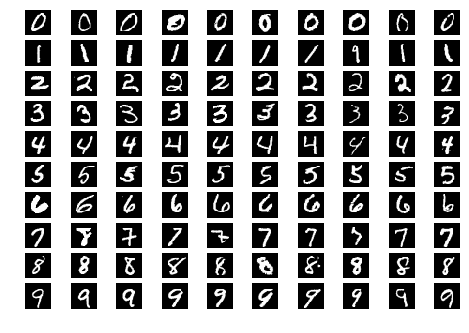

In [0]:
### 1.3

def prediction_indices(y_pred):
  pred_indices = {}
  
  for index,image in enumerate(y_pred):
    prediction = np.argmax(image)
    
    #reshaped_image = 
    if prediction in pred_indices and len(pred_indices[prediction]) < 10:
        pred_indices[prediction] += [index]
    
    elif prediction not in pred_indices:
      pred_indices[prediction] = [index]
      
  return pred_indices



pred_indices = prediction_indices(y_test)



# subplot_index = 0 
for i in range(10): # For digits 
  if i in pred_indices:
    images = pred_indices[i]
    subplot_index = i*10 + 1

    for j in images: # For 10 samples
      plt.subplot(10,10,subplot_index).axis("off")
      subplot_index += 1
      plt.imshow(test_samples[j].reshape((28,28)), cmap='gray')
    
plt.show()


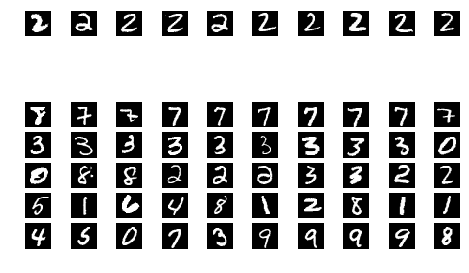

In [0]:
### 1.4

# The second last layer has 1000 rows (samples) and 1024 columns (hidden nodes)
# Randomly pick 10 columns from all the rows for this analysis
random_columns = random.sample(range(0, 1024), 10)
y_second_last_sampled = y_test_layers[-2][:,random_columns]


pred_indices_seclast = prediction_indices(y_second_last_sampled)


# subplot_index = 0 
for i in range(10): # For digits
  if i in pred_indices_seclast:
    images = pred_indices_seclast[i]
    subplot_index = i*10 + 1

    for j in images: # For 10 samples
      plt.subplot(10,10,subplot_index).axis("off")
      subplot_index += 1
      plt.imshow(test_samples[j].reshape((28,28)), cmap='gray')

plt.show()

## Q 1.4

As we randomly chose 10 features (out of 1024) they might not represent all the classes in the data individually. This is because the network has 1024 hidden units at this layer and thus information to discriminate classes with each other is distributed amongst them. Thus, choosing 10 random features and using them might not do a very good job at classifying these images.

The network is trying to come up with different templates to identify the digits and in the process creates a bunch of weak classifiers (1024 in this case). When we randomly pick some of these classifiers (features from the second last layer) and use them to predict we can see that they identify digits with similar curves or shapes as the same digit. 

The ideal situation for this layer would be to learn the most discriminating templates (transformed features) possible. 


Percentage of variance explained by the two features: 17.865565419197083


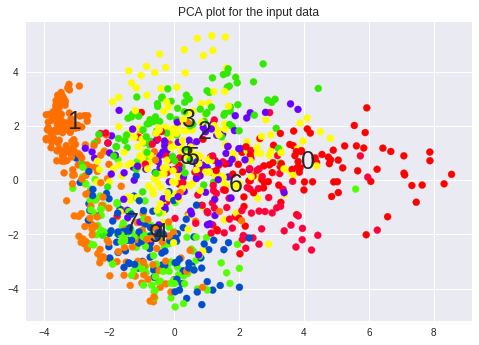

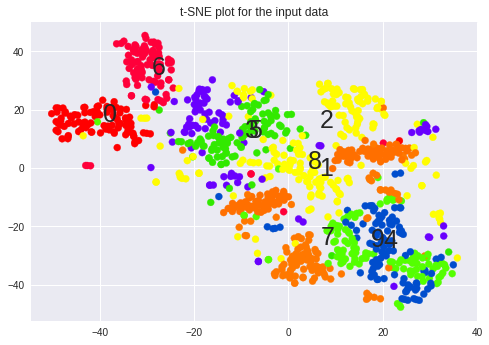

In [0]:
### 1.6

# For this case, X would be a 1000x784 matrix
def get_centroids(X,y):
  df = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"y":y})
  centroids = df.groupby(['y']).agg({"x1":"mean","x2":"mean","y":"first"})
  return centroids.values
  

def pca_tsne_plot(X, y, name_of_layer):
  ### PCA
  pca = PCA(n_components=2)
  X_new = pca.fit_transform(X)
  
  explained_variance = np.sum(pca.explained_variance_ratio_)
  print("Percentage of variance explained by the two features: " + str(explained_variance*100))
  
  pca_centroids = get_centroids(X_new,y)
  
  cmap = plt.cm.get_cmap("prism")
  plt.scatter(X_new[:,0], X_new[:,1], c=y, cmap=cmap)
  
  # Overlay the mean of class 
  for i,v in enumerate(pca_centroids):
    plt.annotate(int(v[2]), (v[0], v[1]),size=25)  
  plt.title("PCA plot for the " + name_of_layer)
  plt.show()
  
  ### TSNE
  X_new_tsne = TSNE(n_components=2).fit_transform(X)
  
  tsne_centroids = get_centroids(X_new_tsne,y)
  plt.scatter(X_new_tsne[:,0], X_new_tsne[:,1], c=y, cmap=cmap)
  
  # Overlay the mean of class 
  for i,v in enumerate(tsne_centroids):
    plt.annotate(int(v[2]), (v[0], v[1]),size=25)
    
  plt.title("t-SNE plot for the " + name_of_layer)
  plt.show()


pca_tsne_plot(test_samples,test_labels,"input data")

## Q 1.6 

No, the raw images are not easy to classify. Most of the digits' clusters are overlapping with others. It looks like the raw images visualized in 2D are not linearly separable. 

The tSNE tries to group points that are closer (nearest neighbors) in n-dimensions into 2D. As the digits with similar curves or shapes have the same pixels lit (features with similar values) the tSNE  tries to group such images. As the features are transformed in the later layers the distances between the points increases and the clusters become more distinct. 

The PCA tries to come up with two features that capture the most variance in the data. Initially this variance captured by the principal components is less and thus the groups are not distinct. We see the segregation becoming clearer as the principal components capture a greater % of the total variance in the later layers (about 50% in the last layer)

Percentage of variance explained by the two features: 20.598094165325165


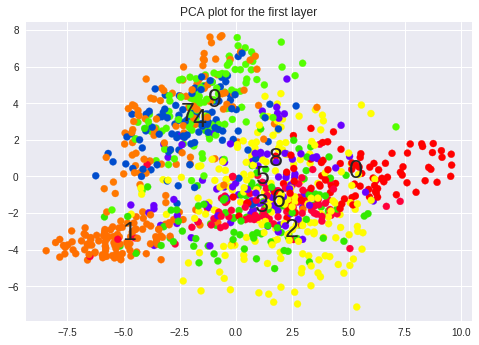

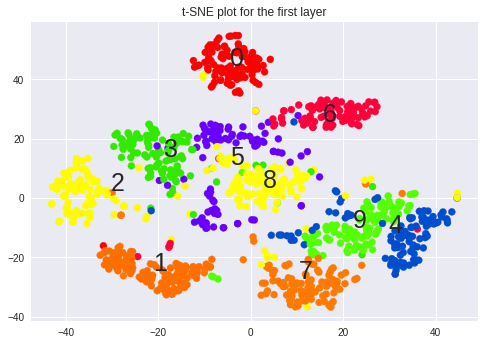

In [0]:
# For the first layer
pca_tsne_plot(y_test_layers[0],test_labels,"first layer")

## Q 1.7

The PCA plot doesn't do a very good job at segregating the clusters as compared to the t-SNE. The variance explained is slightly greater than the input data but not enough to classify images. 



Percentage of variance explained by the two features: 28.285565972328186


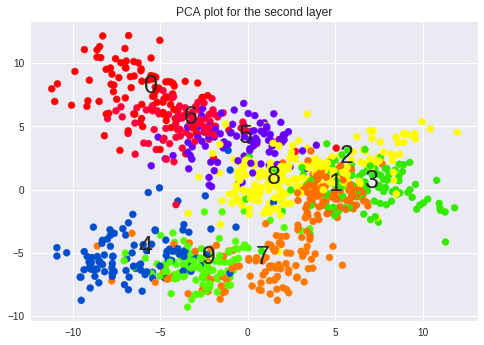

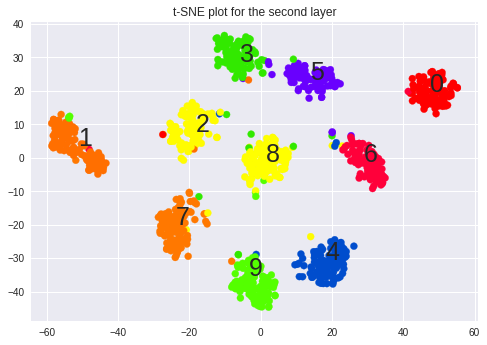

In [0]:
# For the second layer
pca_tsne_plot(y_test_layers[1],test_labels,"second layer")

Percentage of variance explained by the two features: 32.1088582277298


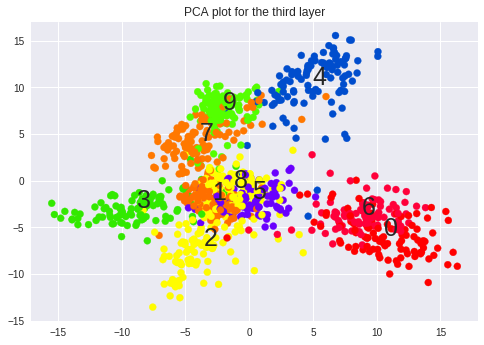

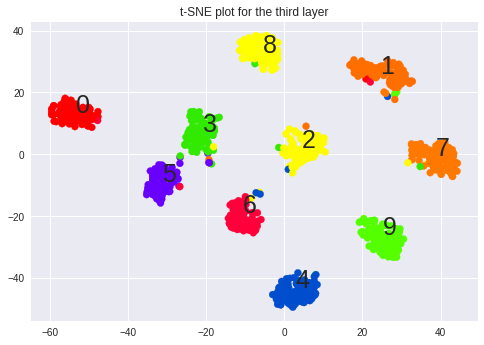

In [0]:
# For the third layer
pca_tsne_plot(y_test_layers[2],test_labels,"third layer")

Percentage of variance explained by the two features: 34.74833071231842


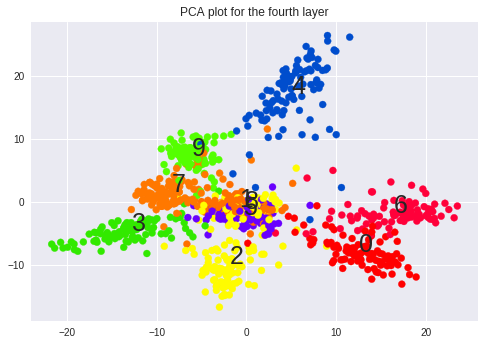

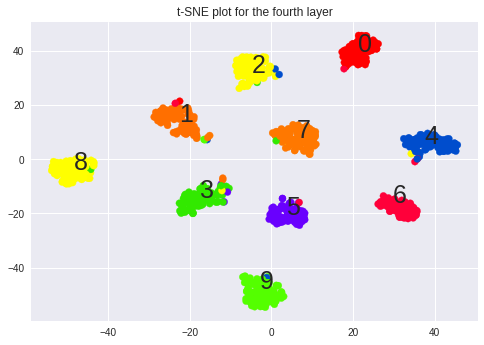

In [0]:
# For the fourth layer
pca_tsne_plot(y_test_layers[3],test_labels,"fourth layer")

Percentage of variance explained by the two features: 38.51815462112427


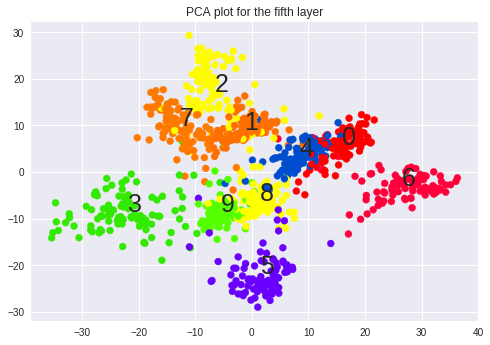

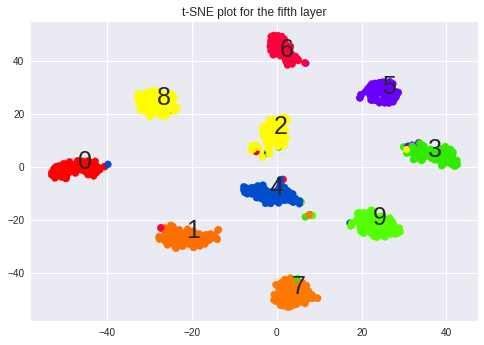

In [0]:
# For the fifth layer
pca_tsne_plot(y_test_layers[4],test_labels,"fifth layer")

Percentage of variance explained by the two features: 48.293522000312805


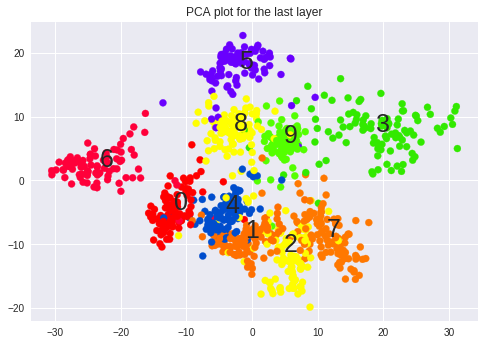

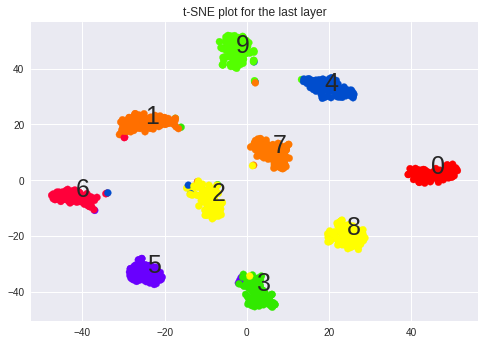

In [0]:
# For the last layer
pca_tsne_plot(y_test_layers[5],test_labels,"last layer")

## Q 1.8

As we observe the layers, we see that the seggregation becomes clearer in the later layers. We can also see the variance explained increasing significantly as we move to the next layers. 

This seems intuitive as the network is transforming data in every layer. It has learned different templates to make this transformation and the result is a matrix with discriminant features. 